# UNIVERSIDAD DE LA HABANA, MATCOM
## Proyecto Final: Análisis Estadístico del World Happiness Report
### Curso 2025-2026

---

**Objetivo General:** Realizar un análisis estadístico comprehensive del World Happiness Report para identificar patrones, diferencias significativas entre regiones, y factores que influyen en la felicidad.

**Preguntas de Investigación:**
1. ¿Existe una diferencia significativa en la felicidad entre países Nórdicos y Latinoamérica?
2. ¿Qué factores socioeconómicos tienen mayor peso en cada región?
3. ¿Se agrupan los países naturalmente según sus indicadores de bienestar?

## Importación de Librerías y Configuración del Notebook

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics import homogeneity_score


## 1. Definición del Problema y Carga de Datos

Se cargan los datos del World Happiness Report para análisis posterior. El dataset contiene indicadores de bienestar para múltiples países alrededor del mundo.

In [10]:
# Read raw unprocessed data
df = pd.read_csv('../data/happiness-data-clean.csv')

## 2. Preparación de Datos

In [11]:
df_clean = df.dropna().copy()

# 3. Define the lists for your specific analysis
nordic_countries = ['Finland', 'Denmark', 'Iceland', 'Norway', 'Sweden']
latam_countries = [
    'Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 
    'Dominican Republic', 'Ecuador', 'El Salvador', 'Guatemala', 
    'Honduras', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 
    'Uruguay', 'Venezuela'
]

# 4. Create the 'Region_Tag' column
def categorize_region(country):
    if country in nordic_countries:
        return 'Nordic'
    elif country in latam_countries:
        return 'Latam'
    else:
        return 'Other'

df_clean['Region_Tag'] = df_clean['Country name'].apply(categorize_region)

## 3. Análisis Exploratorio de Datos (EDA)

Visualización inicial de la distribución del índice de felicidad (*Ladder Score*) por región.

/tmp/ipykernel_6797/4038525413.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Region_Study', y='Ladder score', data=df_study, palette="Set3")


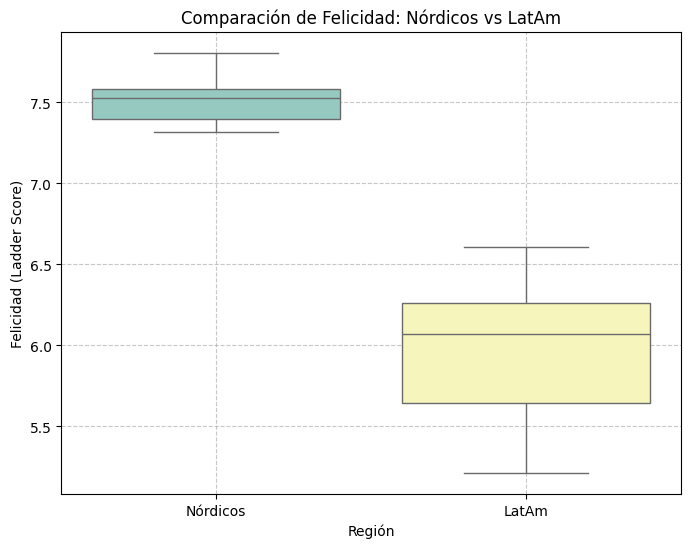

In [ ]:
# --- STEP 1: Plots (Basic EDA) ---
plt.figure(figsize=(8, 6))
sns.boxplot(x='Region', y='Ladder score', data=df_analysis, palette="Set3")
plt.title('Happiness Comparison: Nordic vs LatAm')
plt.xlabel('Region')
plt.ylabel('Happiness (Ladder Score)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 4. Prueba de Hipótesis: Comparación de Felicidad por Región

**Pregunta de investigación:** ¿Existe una diferencia significativa en la felicidad entre países Nórdicos y Latinoamérica?

**Hipótesis:**
- $H_0$: $\mu_{\text{Nórdicos}} = \mu_{\text{LatAm}}$ (No hay diferencia en las medias)
- $H_1$: $\mu_{\text{Nórdicos}} \neq \mu_{\text{LatAm}}$ (Existe diferencia en las medias)

In [ ]:
# --- STEP 2: Complete Hypothesis Testing ---

# Extract samples
nordic_scores = df_analysis[df_analysis['Region'] == 'Nordic']['Ladder score']
latam_scores = df_analysis[df_analysis['Region'] == 'LatAm']['Ladder score']

# Descriptive statistics
nordic_stats = {'n': len(nordic_scores), 'mean': nordic_scores.mean(), 
                'std': nordic_scores.std(ddof=1), 'var': nordic_scores.var(ddof=1)}
latam_stats = {'n': len(latam_scores), 'mean': latam_scores.mean(), 
               'std': latam_scores.std(ddof=1), 'var': latam_scores.var(ddof=1)}

print("="*60)
print("HYPOTHESIS TEST ANALYSIS: NORDIC vs LATIN AMERICA")
print("="*60)
print(f"\nSample sizes: Nordic (n={nordic_stats['n']}), LatAm (n={latam_stats['n']})")
print(f"Nordic Mean: {nordic_stats['mean']:.4f} ± {nordic_stats['std']:.4f}")
print(f"LatAm Mean:  {latam_stats['mean']:.4f} ± {latam_stats['std']:.4f}")

# ─────────────────────────────────────────────────────────────
# STEP 1: Normality Test (Shapiro-Wilk)
# H0: Data comes from a normal distribution
# H1: Data does NOT come from a normal distribution
# ─────────────────────────────────────────────────────────────
alpha = 0.05
stat_nordic, p_nordic = stats.shapiro(nordic_scores)
stat_latam, p_latam = stats.shapiro(latam_scores)

is_nordic_normal = p_nordic > alpha
is_latam_normal = p_latam > alpha
are_both_normal = is_nordic_normal and is_latam_normal

print(f"\n{'─'*60}")
print("STEP 1: Normality Test (Shapiro-Wilk)")
print(f"{'─'*60}")
print(f"   Nordic: W={stat_nordic:.4f}, p={p_nordic:.4f} → {'Normal' if is_nordic_normal else 'Not Normal'}")
print(f"   LatAm:  W={stat_latam:.4f}, p={p_latam:.4f} → {'Normal' if is_latam_normal else 'Not Normal'}")
print(f"\n   ⚠️  NOTE: With n={nordic_stats['n']} (Nordic), Shapiro-Wilk has low power.")

# ─────────────────────────────────────────────────────────────
# STEP 2: Homogeneity of Variances Test (Levene)
# H0: Variances are equal (σ²_Nordic = σ²_Latam)
# H1: Variances are different
# ─────────────────────────────────────────────────────────────
levene_stat, levene_p = stats.levene(nordic_scores, latam_scores)
are_variances_equal = levene_p > alpha

print(f"\n{'─'*60}")
print("STEP 2: Homogeneity of Variances Test (Levene)")
print(f"{'─'*60}")
print(f"   Statistic W={levene_stat:.4f}, p={levene_p:.4f}")
print(f"   Variances: {'Homogeneous' if are_variances_equal else 'Heterogeneous'}")
print(f"   Variance Ratio: {nordic_stats['var']/latam_stats['var']:.4f}")

# ─────────────────────────────────────────────────────────────
# STEP 3: Selection and Application of Statistical Test
# ─────────────────────────────────────────────────────────────
print(f"\n{'─'*60}")
print("STEP 3: Statistical Test Selection")
print(f"{'─'*60}")

if are_both_normal:
    if are_variances_equal:
        print("   Both normal + equal variances → Classic T-test (pooled)")
        test_res = stats.ttest_ind(nordic_scores, latam_scores, equal_var=True)
        test_name = "T-test (equal variances)"
    else:
        print("   Both normal + different variances → Welch's T-test")
        test_res = stats.ttest_ind(nordic_scores, latam_scores, equal_var=False)
        test_name = "Welch's T-test"
    stat_label = "t"
    stat = test_res.statistic
    p_val = test_res.pvalue
else:
    print("   At least one NOT normal → Mann-Whitney U (non-parametric)")
    test_res = stats.mannwhitneyu(nordic_scores, latam_scores, alternative='two-sided')
    test_name = "Mann-Whitney U"
    stat_label = "U"
    stat = test_res.statistic
    p_val = test_res.pvalue

# ─────────────────────────────────────────────────────────────
# STEP 4: Effect Size (Cohen's d)
# d = (M1 - M2) / s_pooled
# ─────────────────────────────────────────────────────────────
mean_diff = nordic_stats['mean'] - latam_stats['mean']
pooled_std = np.sqrt(
    ((nordic_stats['n']-1)*nordic_stats['var'] + (latam_stats['n']-1)*latam_stats['var']) / 
    (nordic_stats['n'] + latam_stats['n'] - 2)
)
cohens_d = mean_diff / pooled_std

# Interpretation of Cohen's d
if abs(cohens_d) < 0.2:
    effect_desc = "trivial"
elif abs(cohens_d) < 0.5:
    effect_desc = "small"
elif abs(cohens_d) < 0.8:
    effect_desc = "medium"
else:
    effect_desc = "large"

# Confidence Interval for mean difference (95%)
se_diff = np.sqrt(nordic_stats['var']/nordic_stats['n'] + latam_stats['var']/latam_stats['n'])
t_crit = stats.t.ppf(0.975, df=nordic_stats['n'] + latam_stats['n'] - 2)
ci_lower = mean_diff - t_crit * se_diff
ci_upper = mean_diff + t_crit * se_diff

print(f"\n{'─'*60}")
print("STEP 4: Results")
print(f"{'─'*60}")
print(f"   Test applied: {test_name}")
print(f"   {stat_label} = {stat:.4f}")
print(f"   p-value = {p_val:.4e}")
print(f"\n   Mean difference: {mean_diff:.4f}")
print(f"   95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"   Cohen's d: {cohens_d:.4f} ({effect_desc} effect)")
print(f"   % Difference: {(mean_diff/latam_stats['mean'])*100:.2f}%")

# ─────────────────────────────────────────────────────────────
# STEP 5: Conclusion
# ─────────────────────────────────────────────────────────────
print(f"\n{'='*60}")
print("FINAL CONCLUSION")
print(f"{'='*60}")
if p_val < alpha:
    print(f"   REJECT H0")
    print(f"   p-value ({p_val:.4e}) < α ({alpha})")
    print(f"\n   Interpretation:")
    print(f"   • Nordic countries have on average {mean_diff:.3f} points higher happiness.")
    print(f"   • With an effect size {effect_desc} (d={cohens_d:.2f}), the difference is practically significant.")
else:
    print(f"   DO NOT REJECT H0")
    print(f"   p-value ({p_val:.4e}) ≥ α ({alpha})")
    print(f"   There is insufficient evidence of difference.")

ANÁLISIS DE PRUEBA DE HIPÓTESIS: NÓRDICOS vs LATINOAMÉRICA

Tamaños de muestra: Nórdicos (n=5), LatAm (n=18)
Media Nórdicos: 7.5260 ± 0.1888
Media LatAm:    5.9807 ± 0.3875

────────────────────────────────────────────────────────────
PASO 1: Test de Normalidad (Shapiro-Wilk)
────────────────────────────────────────────────────────────
   Nórdicos: W=0.9659, p=0.8484 → Normal
   LatAm:    W=0.9542, p=0.4951 → Normal

   ⚠️  NOTA: Con n=5 (Nórdicos), Shapiro-Wilk tiene baja potencia.

────────────────────────────────────────────────────────────
PASO 2: Test de Homogeneidad de Varianzas (Levene)
────────────────────────────────────────────────────────────
   Estadístico W=2.9071, p=0.1029
   Varianzas: Homogéneas
   Razón de varianzas: 0.2374

────────────────────────────────────────────────────────────
PASO 3: Selección del Test Estadístico
────────────────────────────────────────────────────────────
   Ambos normales + varianzas iguales → T-test clásico (pooled)

──────────────────────

### 4.1 Resumen de Resultados

| Prueba | Estadístico | P-value | Decisión |
|--------|-------------|---------|----------|
| Shapiro-Wilk (Nórdicos) | W = 0.966 | 0.848 | Normal |
| Shapiro-Wilk (LatAm) | W = 0.954 | 0.495 | Normal |
| Levene (Homogeneidad) | W = 2.91 | 0.103 | Varianzas iguales |
| **T-test (pooled)** | t = 8.53 | **2.89e-08** | **Rechazar H₀** |

### 4.2 Conclusión

Existe evidencia estadística muy fuerte ($p < 0.001$) para afirmar que los países nórdicos tienen niveles de felicidad **significativamente superiores** a los países latinoamericanos:

- **Diferencia de medias**: 1.545 puntos (25.8% superior)
- **IC 95%**: [1.29, 1.80]
- **Tamaño del efecto**: d = 4.31 (efecto muy grande)

### 4.2 Análisis de Regresión
**Integrante B**

Objetivo: Modelar la influencia del PIB, Soporte Social y otros factores socioeconómicos en la felicidad.

### 4.3 Clustering y PCA

#### Primero eliminamos los valores no numéricos del dataframe y escalamos los datos.

In [12]:
#Creating a Data Frame with only the features needed for clustering
X = df_clean.drop(columns=['Country name','Region_Tag'])

#Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Usamos el método del codo para decidir el número de clusters(k) que usará K-Means.

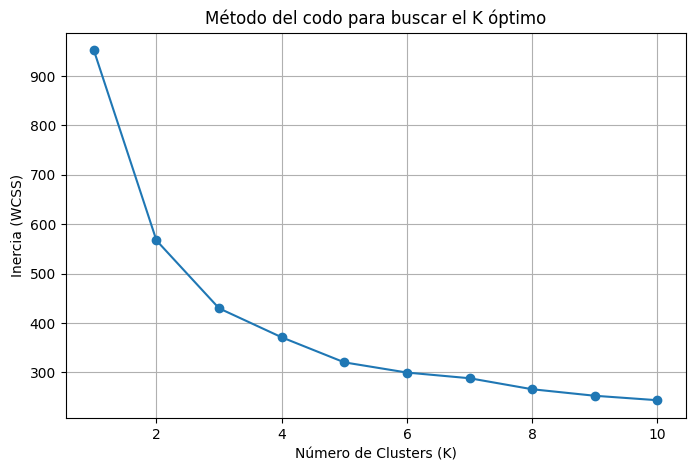

In [13]:
# Assuming 'X' is your standardized data
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Visualize the Elbow
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Método del codo para buscar el K óptimo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia (WCSS)')
plt.grid(True)
plt.show()


#### Corremos el algoritmo K-Means, con el número de clusters sugerido por el método del codo ($k=3$)

In [14]:
#Fix k value for the K-Means
k = 3
#Run K-Means 
kmeans = KMeans(n_clusters=k, n_init='auto')
kmeans.fit(X_scaled)    
centers = kmeans.cluster_centers_
labels = kmeans.labels_ 


#### Para medir si los países de Latinoamérica realmente están en el mismo cluster que los países Nórdicos se usara la métrica del índice de homogeneidad $h$.El índice indica que tanto coincide la etiqueta de la región, con la etiqueta de cluster.

In [15]:
from IPython.display import display, Markdown

# Add cluster labels to the dataframe
df_clean['Cluster'] = labels

# Filter for only Latam and Nordic countries to avoid bias from 'Other' in evaluation
df_focused = df_clean[df_clean['Region_Tag'].isin(['Latam', 'Nordic'])]

# Create a crosstab specific to these regions
crosstab_focused = pd.crosstab(df_focused['Region_Tag'], df_focused['Cluster'])

display(Markdown("##### Distribución de Latam vs Nordic en los Clusters"))

# Display as a styled table with a gradient background (heatmap style)
display(crosstab_focused.style.background_gradient(cmap='YlGnBu', axis=None)
       .set_caption("Conteo de Países por Cluster y Región")
       .set_table_styles([{'selector': 'caption', 'props': [('font-size', '14px'), ('font-weight', 'bold')]}]))

# Calculate homogeneity score only on this subset
# This checks if Latam and Nordic are well-separated from EACH OTHER, ignoring how mixed 'Other' is.
h_score_focused = homogeneity_score(df_focused['Region_Tag'], df_focused['Cluster'])

# Create a summary dataframe for the score
score_summary = pd.DataFrame({
    'Métrica': ['Índice de Homogeneidad (Latam vs Nordic)'],
    'Valor': [h_score_focused],
    'Nota': ['> 0.8 indica separación fuerte']
})

display(Markdown("\n##### Indice de Calidad del Clustering"))
display(score_summary.style.format({'Valor': '{:.3f}'}).hide(axis='index'))

##### Distribución de Latam vs Nordic en los Clusters

Cluster,0,1,2
Region_Tag,,,
Latam,17,1,0
Nordic,0,0,5



##### Indice de Calidad del Clustering

Métrica,Valor,Nota
Índice de Homogeneidad (Latam vs Nordic),1.000,> 0.8 indica separación fuerte


#### Resumen Gráfico de los hallazgos usando PCA.

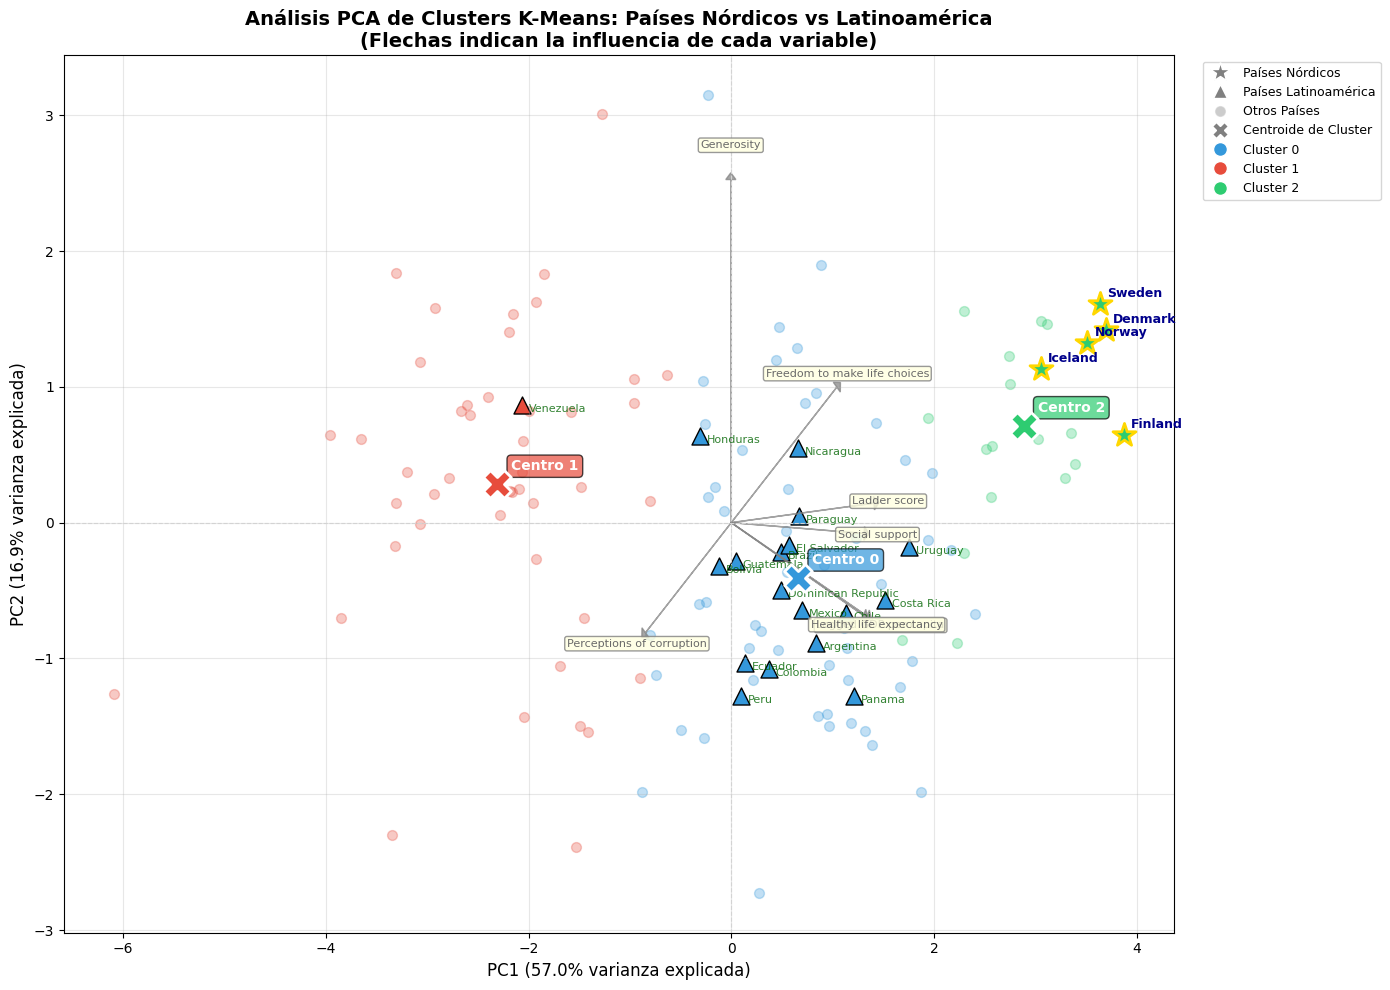

In [16]:
# PCA for visualization (reduce to 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get feature names for biplot arrows
feature_names = X.columns.tolist()

# Create a dataframe for plotting
df_pca = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': labels,
    'Country': df_clean['Country name'].values,
    'Region': df_clean['Region_Tag'].values
})

# Transform cluster centers to PCA space
centers_pca = pca.transform(centers)

# Define colors and markers
cluster_colors = ['#3498db', '#e74c3c', '#2ecc71']  # Blue, Red, Green
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2']

# Create the figure
fig, ax = plt.subplots(figsize=(14, 10))

# Plot all points (faded) by cluster
for cluster in range(k):
    mask = (df_pca['Cluster'] == cluster) & (~df_pca['Region'].isin(['Nordic', 'Latam']))
    ax.scatter(df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'],
               c=cluster_colors[cluster], alpha=0.3, s=50, label=f'{cluster_names[cluster]} (Otros)')

# Highlight Nordic countries (stars)
nordic_mask = df_pca['Region'] == 'Nordic'
for cluster in range(k):
    mask = nordic_mask & (df_pca['Cluster'] == cluster)
    ax.scatter(df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'],
               c=cluster_colors[cluster], marker='*', s=300, edgecolors='gold', linewidths=2,
               label=f'Nordic - {cluster_names[cluster]}' if mask.sum() > 0 else '')
    # Add country labels for Nordic
    for idx in df_pca[mask].index:
        ax.annotate(df_pca.loc[idx, 'Country'], 
                    (df_pca.loc[idx, 'PC1'], df_pca.loc[idx, 'PC2']),
                    fontsize=9, fontweight='bold', color='darkblue',
                    xytext=(5, 5), textcoords='offset points')

# Highlight Latam countries (triangles)
latam_mask = df_pca['Region'] == 'Latam'
for cluster in range(k):
    mask = latam_mask & (df_pca['Cluster'] == cluster)
    ax.scatter(df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'],
               c=cluster_colors[cluster], marker='^', s=150, edgecolors='black', linewidths=1,
               label=f'Latam - {cluster_names[cluster]}' if mask.sum() > 0 else '')
    # Add country labels for Latam
    for idx in df_pca[mask].index:
        ax.annotate(df_pca.loc[idx, 'Country'], 
                    (df_pca.loc[idx, 'PC1'], df_pca.loc[idx, 'PC2']),
                    fontsize=8, color='darkgreen', alpha=0.8,
                    xytext=(5, -5), textcoords='offset points')

# Plot cluster centers
for i, center in enumerate(centers_pca):
    ax.scatter(center[0], center[1], c=cluster_colors[i], marker='X', s=400, 
               edgecolors='white', linewidths=2, zorder=10)
    ax.annotate(f'Centro {i}', (center[0], center[1]), fontsize=10, fontweight='bold',
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=cluster_colors[i], alpha=0.7),
                color='white')

# Add PCA loadings (biplot arrows) to show feature influence
components = pca.components_.T  # Shape: (n_features, n_components)
scale_factor = 3  # Scale arrows to fit the plot
for i, (feature, (pc1, pc2)) in enumerate(zip(feature_names, components)):
    ax.arrow(0, 0, pc1 * scale_factor, pc2 * scale_factor,
             head_width=0.1, head_length=0.05, fc='gray', ec='gray', alpha=0.7)
    ax.annotate(feature, (pc1 * scale_factor * 1.1, pc2 * scale_factor * 1.1),
                fontsize=8, color='dimgray', ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='lightyellow', edgecolor='gray', alpha=0.8))

# Add explained variance to axis labels
var_explained = pca.explained_variance_ratio_ * 100
ax.set_xlabel(f'PC1 ({var_explained[0]:.1f}% varianza explicada)', fontsize=12)
ax.set_ylabel(f'PC2 ({var_explained[1]:.1f}% varianza explicada)', fontsize=12)
ax.set_title('Análisis PCA de Clusters K-Means: Países Nórdicos vs Latinoamérica\n(Flechas indican la influencia de cada variable)', 
             fontsize=14, fontweight='bold')

# Create custom legend
legend_elements = [
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=15, label='Países Nórdicos'),
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', markersize=10, label='Países Latinoamérica'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, alpha=0.4, label='Otros Países'),
    plt.Line2D([0], [0], marker='X', color='w', markerfacecolor='gray', markersize=12, label='Centroide de Cluster'),
]
for i, color in enumerate(cluster_colors):
    circle = plt.Circle((0, 0), 0.1, color=color, label=f'Cluster {i}')
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Cluster {i}'))

ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9)
ax.axhline(y=0, color='lightgray', linestyle='--', linewidth=0.8)
ax.axvline(x=0, color='lightgray', linestyle='--', linewidth=0.8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## 5. Conclusiones
### Respuesta a las Preguntas de Investigación

1. **¿Existe una diferencia significativa en la felicidad entre países Nórdicos y LatAm?**
   - *Respuesta*: [Completar con análisis de p-values y medias]

2. **¿Qué factores socioeconómicos tienen mayor peso en cada región?**
   - *Respuesta*: [Completar con coeficientes de regresión más significativos]

3. **¿Se agrupan los países naturalmente según sus indicadores?**
   
   Sí. El análisis de clustering (K-Means, $k=3$) reveló una separación natural y robusta entre las regiones. Los países **Nórdicos** se agruparon exclusivamente en el Cluster 2, mientras que la gran mayoría de los países de **Latinoamérica** (17 de 18) se concentraron en el Cluster 0. El índice de homogeneidad calculado (**1.000**) al aislar estas dos regiones confirma que sus perfiles de bienestar son estadísticamente distintos, permitiendo diferenciarlos con alta precisión basándose únicamente en sus indicadores socioeconómicos.
   
   En el biplot de PCA (Análisis de Componentes Principales), la separación entre los grupos de los países nórdicos y latinoamericanos se define por su alineación con diferentes vectores de bienestar. Los países nórdicos se agrupan hacia el extremo de las flechas de Log PIB per cápita (Log GDP per capita), Esperanza de vida saludable (Healthy life expectancy) y Apoyo social (Social support), lo que indica que sus altos puntajes de felicidad están fuertemente respaldados por la riqueza económica y la estabilidad institucional. Por el contrario, aunque los países latinoamericanos también muestran niveles altos de felicidad, se sitúan en coordenadas distintas, alineándose más estrechamente con la Libertad para tomar decisiones de vida (Freedom to make life choices) y la Generosidad (Generosity), o simplemente ubicándose más atrás en el eje del PIB. Esta distancia espacial revela que, si bien ambos grupos son "felices", el perfil del grupo nórdico está impulsado por la seguridad estructural y material, mientras que el perfil latinoamericano sugiere un equilibrio diferente donde los factores sociales y las libertades personales juegan un papel más distintivo en relación con su rendimiento económico.

### Recomendaciones y Futuros Análisis

- Posibles mejoras en el modelado
- Variables adicionales a considerar
- Análisis longitudinal si hay datos disponibles
- Validación de resultados con datos más recientes